In [1]:
import numpy as np
from scipy.stats import norm, ks_2samp
import pandas as pd

def w1_empirical_vs_true_quantile(sample, true_ppf, grid_u):
    """
    Approximate W1(F_n, F) in 1D by:
        W1 = ∫_0^1 |Q_n(u) - Q(u)| du
    using an equally spaced grid in u.
    """
    x = np.sort(sample)
    n = len(x)

    # Empirical quantile at u: Q_n(u) ~ x[ceil(nu)-1]
    idx = np.ceil(grid_u * n).astype(int) - 1
    idx = np.clip(idx, 0, n - 1)
    qn = x[idx]

    q = true_ppf(grid_u)
    return np.mean(np.abs(qn - q))  # since grid_u equally spaced on [0,1]


def brownian_bridge_paths(n_paths, m_grid, seed=0):
    """
    Simulate Brownian bridge B(t) on t-grid in [0,1]:
        B(t) = W(t) - t W(1)
    using discretized Brownian motion.
    Returns:
        t (m_grid,), B (n_paths, m_grid)
    """
    rng = np.random.default_rng(seed)
    t = np.linspace(0.0, 1.0, m_grid)
    dt = t[1] - t[0]

    dW = rng.normal(0.0, np.sqrt(dt), size=(n_paths, m_grid - 1))
    W = np.concatenate([np.zeros((n_paths, 1)), np.cumsum(dW, axis=1)], axis=1)
    B = W - t[None, :] * W[:, [-1]]
    return t, B


def bridge_functional_L(B, u_grid, Q_u):
    """
    Approximate L = ∫ |B(u)| dQ(u) as a Riemann–Stieltjes sum:
        sum_j |B(u_j)| * (Q(u_{j+1}) - Q(u_j))
    with u_grid increasing.
    B can be shape (m_grid,) or (n_paths, m_grid).
    """
    dQ = np.diff(Q_u)  # length m_grid-1
    if B.ndim == 1:
        return np.sum(np.abs(B[:-1]) * dQ)
    else:
        return np.sum(np.abs(B[:, :-1]) * dQ[None, :], axis=1)


In [2]:
def run_experiment(
    n_list=(10, 30, 50, 100, 1000),
    n_rep=2000,          # number of iid samples per n
    n_bridge=20000,      # number of Brownian bridge paths for reference distribution
    m_grid=4000,
    eps=1e-4,
    seed=123
):
    rng = np.random.default_rng(seed)

    # u-grid avoiding 0 and 1 because Normal quantiles blow up
    u = np.linspace(eps, 1.0 - eps, m_grid)
    Q_u = norm.ppf(u)

    # simulate Brownian bridge reference once
    _, B = brownian_bridge_paths(n_paths=n_bridge, m_grid=m_grid, seed=seed + 1)
    L = bridge_functional_L(B, u, Q_u)  # shape (n_bridge,)

    rows = []
    for n in n_list:
        # simulate T_n = sqrt(n) * W1(F_n, F)
        T = np.empty(n_rep)
        for r in range(n_rep):
            x = rng.normal(0.0, 1.0, size=n)
            w1 = w1_empirical_vs_true_quantile(x, norm.ppf, u)
            T[r] = np.sqrt(n) * w1

        ks = ks_2samp(T, L, alternative="two-sided", mode="auto")

        rows.append({
            "n": n,
            "n_rep": n_rep,
            "n_bridge": n_bridge,
            "KS_stat": float(ks.statistic),
            "KS_pvalue": float(ks.pvalue),
            "T_mean": float(np.mean(T)),
            "T_sd": float(np.std(T, ddof=1)),
            "L_mean": float(np.mean(L)),
            "L_sd": float(np.std(L, ddof=1)),
        })

    return pd.DataFrame(rows), L

df, L = run_experiment()
df


,n,n_rep,n_bridge,KS_stat,KS_pvalue,T_mean,T_sd,L_mean,L_sd
0,10,2000,20000,0.05220,0.000096,1.233087,0.434496,1.276182,0.442284
1,30,2000,20000,0.03810,0.009938,1.251228,0.439452,1.276182,0.442284
2,50,2000,20000,0.03740,0.012051,1.255177,0.440577,1.276182,0.442284
3,100,2000,20000,0.02245,0.314029,1.271539,0.453869,1.276182,0.442284
4,1000,2000,20000,0.02195,0.340176,1.285524,0.447484,1.276182,0.442284


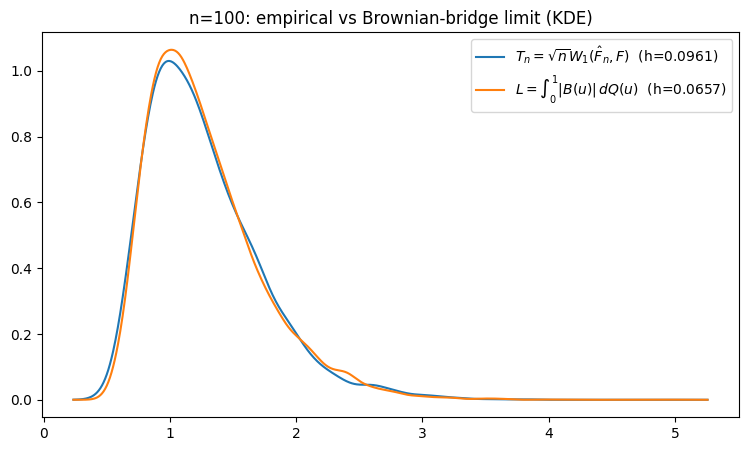

,n,n_rep,n_bridge,KS_stat,KS_pvalue,T_mean,T_sd,L_mean,L_sd
0,100,3000,20000,0.015333,0.566355,1.27084,0.449641,1.276777,0.449204


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def kde_gaussian(x, grid, bandwidth=None):
    """
    Simple Gaussian KDE (no seaborn).
    bandwidth default: Silverman's rule.
    """
    x = np.asarray(x)
    n = x.size
    if bandwidth is None:
        sd = np.std(x, ddof=1)
        bandwidth = 1.06 * sd * n ** (-1/5)
        if not np.isfinite(bandwidth) or bandwidth <= 0:
            bandwidth = 1e-3

    z = (grid[:, None] - x[None, :]) / bandwidth
    dens = np.mean(np.exp(-0.5 * z**2), axis=1) / (bandwidth * np.sqrt(2*np.pi))
    return dens, bandwidth

def compare_kde(T, L, title=""):
    T = np.asarray(T)
    L = np.asarray(L)

    lo = min(T.min(), L.min())
    hi = max(T.max(), L.max())
    pad = 0.05 * (hi - lo) if hi > lo else 1.0
    grid = np.linspace(lo - pad, hi + pad, 800)

    fT, hT = kde_gaussian(T, grid)
    fL, hL = kde_gaussian(L, grid)

    plt.figure(figsize=(9, 5))
    plt.plot(grid, fT, label=rf"$T_n=\sqrt{{n}}W_1(\hat F_n,F)$  (h={hT:.3g})")
    plt.plot(grid, fL, label=rf"$L=\int_0^1 |B(u)|\,dQ(u)$  (h={hL:.3g})")
    plt.title(title)
    plt.legend()
    plt.show()

# Example: re-run for a single n and plot
n = 100
df_single, L = run_experiment(n_list=(n,), n_rep=3000, n_bridge=20000, seed=321)

rng = np.random.default_rng(321)
m_grid = 4000
eps = 1e-4
u = np.linspace(eps, 1.0 - eps, m_grid)

T = []
for _ in range(3000):
    x = rng.normal(size=n)
    w1 = w1_empirical_vs_true_quantile(x, norm.ppf, u)
    T.append(np.sqrt(n) * w1)
T = np.array(T)

compare_kde(T, L, title=f"n={n}: empirical vs Brownian-bridge limit (KDE)")
df_single

